#Importing the libraries

In [ ]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
stopwords_list ='stopwords-bn.txt'

#Importing dataset

In [ ]:
data = pd.read_excel('/content/bengali_restaurant_reviews.xlsx')
print("Total Reviews:",len(data),
      "\nTotal Positive Reviews:",len(data[data.Sentiment =='positive']),
      "\nTotal Negative Reviews:",len(data[data.Sentiment=='negative']))

Total Reviews: 1431 
Total Positive Reviews: 637 
Total Negative Reviews: 794


In [ ]:
data.columns

Index(['Unnamed: 0', 'Reviews', 'Sentiment'], dtype='object')

#Here are some unprocessed reviews

In [ ]:
sample_data = [10,100,150,200,250,600,650,666,689,640,650,700,750,800,1000]
for i in sample_data:
      print(data.Reviews[i],'\n','Sentiment:-- ',data.Sentiment[i],'\n')

ব্রিলিয়ান্ট......।। 
 Sentiment:--  positive 

চমৎকার এবং বন্ধুত্বপূর্ণ পরিবেশ .. ভাল খাবার .. আমার মতে সেট মেনুটা সেরা। এটা বজায় রাখেন. 
 Sentiment:--  positive 

চিকেনের স্বাদটা অসাধারণ,অতিরিক্ত সুস্বাদু, তাদের মুরগির আইটেমগুলো পছন্দনীয়। 
 Sentiment:--  positive 

করররররররা। 
 Sentiment:--  positive 

গ্রেট খাবার, ভাল জায়গা, ভাল মূল্য এবং কর্মচারীরাও ভালো :) 
 Sentiment:--  positive 

এই স্থানটি আমার সাম্প্রতিক প্রিয় বিশেষভাবে তাদের বার্গার ভালোবাসি এই জন্য চার বার ইতিমধ্যে স্টাফ আচরণ সত্যিই ভাল সংযমের দর্শন আবার ক্যাপ্টেন কুক রেঁস্তোরা ধন্যবাদ আপনি 
 Sentiment:--  positive 

গ্রিলটা ঠান্ডা ছিল, রুটিও শুকনো এবং শক্ত ছিল, স্টকটা পুরাতন ছিল ... খুবই খারাপ মানের খাবার ... হতাশ ... 
 Sentiment:--  negative 

ধানমন্ডি শাখায় খাবারের গুণগত মান সবচেয়ে খারাপ এবং সার্ভিসের ক্ষেত্রেও সবচেয়ে খারাপ।  এমন ভয়ঙ্কর অভিজ্ঞতার মধ্য দিয়ে আমি আর কখনো যাইনি  এবং খাবারের দামের ক্ষেত্রেও ভয়ঙ্কর অভিজ্ঞতা। আর আসবনা এখানে। 
 Sentiment:--  negative 

নোংরা টয়লেট, লেট সার্ভিস। তাছাড়া কাস্টমার কেয়ারের কর

#Data Processing

In [ ]:
from utils import cleaned_reviews,stopwords_info,stopword_removal,process_reviews


In [ ]:
# Apply the function into the dataframe
data['cleaned'] = data['Reviews'].apply(process_reviews,stopwords = stopwords_list,removing_stopwords = True)

# print some cleaned reviews from the dataset
sample_data = [10,100,150,200,250,600,650,666,689,640,650,700,750,800,1000]
for i in sample_data:
      print('Original:\n',data.Reviews[i],'\nCleaned:\n',data.cleaned[i],'\n','Sentiment:-- ',data.Sentiment[i],'\n')

Original:
 ব্রিলিয়ান্ট......।। 
Cleaned:
 ব্রিলিয়ান্ট 
 Sentiment:--  positive 

Original:
 চমৎকার এবং বন্ধুত্বপূর্ণ পরিবেশ .. ভাল খাবার .. আমার মতে সেট মেনুটা সেরা। এটা বজায় রাখেন. 
Cleaned:
 চমৎকার বন্ধুত্বপূর্ণ পরিবেশ ভাল খাবার মতে সেট মেনুটা সেরা বজায় রাখেন 
 Sentiment:--  positive 

Original:
 চিকেনের স্বাদটা অসাধারণ,অতিরিক্ত সুস্বাদু, তাদের মুরগির আইটেমগুলো পছন্দনীয়। 
Cleaned:
 চিকেনের স্বাদটা অসাধারণ অতিরিক্ত সুস্বাদু মুরগির আইটেমগুলো পছন্দনীয় 
 Sentiment:--  positive 

Original:
 করররররররা। 
Cleaned:
 করররররররা 
 Sentiment:--  positive 

Original:
 গ্রেট খাবার, ভাল জায়গা, ভাল মূল্য এবং কর্মচারীরাও ভালো :) 
Cleaned:
 গ্রেট খাবার ভাল জায়গা ভাল মূল্য কর্মচারীরাও ভালো 
 Sentiment:--  positive 

Original:
 এই স্থানটি আমার সাম্প্রতিক প্রিয় বিশেষভাবে তাদের বার্গার ভালোবাসি এই জন্য চার বার ইতিমধ্যে স্টাফ আচরণ সত্যিই ভাল সংযমের দর্শন আবার ক্যাপ্টেন কুক রেঁস্তোরা ধন্যবাদ আপনি 
Cleaned:
 স্থানটি সাম্প্রতিক প্রিয় বিশেষভাবে বার্গার ভালোবাসি ইতিমধ্যে স্টাফ আচরণ সত্যিই ভাল সংযমের দর্শন 

# Removing low length data

In [ ]:
# Length of each Reveiws
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
# Remove the reviews with least words
dataset = data.loc[data.length>2]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Reviews".format(len(data)-len(dataset)),
      "\nTotal Reviews:",len(dataset),
      "\nTotal Positive Reviews:",len(dataset[dataset.Sentiment =='positive']),
      "\nTotal Negative Reviews:",len(dataset[dataset.Sentiment=='negative']))

After Cleaning: 
Removed 91 Small Reviews 
Total Reviews: 1340 
Total Positive Reviews: 569 
Total Negative Reviews: 771


In [ ]:
#write the clean data to another excel
dataset[['cleaned','Sentiment']].to_excel('clean_rr_reviews.xlsx')


# Saving the cleaned data and stopwords into a pickle file


In [ ]:
data = pd.read_excel('clean_rr_reviews.xlsx')


In [ ]:
# open a file, where you ant to store the data, using a pickle file
file = open('rr_review_data.pkl', 'wb')
# dump information to that file
pickle.dump(data, file)

In [ ]:
# load the save file
data = open('rr_review_data.pkl','rb')
data = pickle.load(data)

In [ ]:
# Stopwords pickle
stp = open(stopwords_list,'r', encoding='utf-8').read().split()
# open a file, where you ant to store the data
file = open('rr_stopwords.pkl', 'wb')
# dump information to that file
pickle.dump(stp, file)

In [ ]:
stp = open('rr_stopwords.pkl','rb')
stp = pickle.load(stp)
len(stp)

387

In [ ]:
#processing of a sample review
tweet = 'খাবার ভাল ছিল, তাছাড়া পরিবেশটা ও চমৎকার ।। ।।!!!!'
process_reviews(review = tweet, stopwords =stopwords_list,removing_stopwords=True)

'খাবার ভাল তাছাড়া পরিবেশটা চমৎকার'

#Dataset summary

In [ ]:
from utils import data_summary
documents,words,u_words,class_names = data_summary(dataset)


Class Name :  negative
Number of Documents:771
Number of Words:12976
Number of Unique Words:3291
Most Frequent Words:

না	395
খাদ্য	326
খারাপ	323
ভাল	195
খাবার	147
সেবা	120
স্বাদ	111
মত	76
মুরগির	74
সময়	73

Class Name :  positive
Number of Documents:569
Number of Words:5923
Number of Unique Words:1578
Most Frequent Words:

ভাল	302
খাদ্য	174
খাবার	164
জায়গা	121
চমৎকার	108
সুস্বাদু	80
পরিবেশ	77
সেবা	72
সেরা	66
সত্যিই	58


#Visualization

In [ ]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
print(df)

  Class Names         Category  Values
0    negative  Total Documents     771
1    positive  Total Documents     569
2    negative      Total Words   12976
3    positive      Total Words    5923
4    negative     Unique Words    3291
5    positive     Unique Words    1578


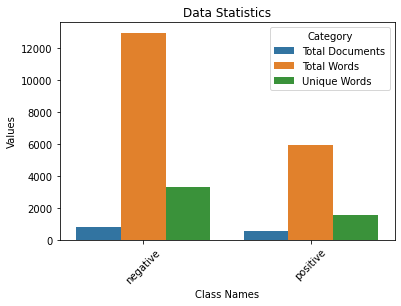

In [ ]:
plt.figure(figsize=(6, 4))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names')
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

#Using TF IDF (term frequency for bigram and trigram)

In [ ]:
from utils import calc_unigram_tfidf,calc_bigram_tfidf,calc_trigram_tfidf,show_tfidf


In [ ]:
tweet = 'খাবার ভাল ছিল, তাছাড়া পরিবেশটা ও চমৎকার ।। ।।!!!!'  #the food was good and the atmosphere was also nice
cv,feature_vector = calc_trigram_tfidf(dataset.cleaned)
#print("Shape of TF-IDF Corpus =====>",feature_vector.shape,'\n')
show_tfidf(cv,tweet)


Sample Review:  খাবার ভাল ছিল, তাছাড়া পরিবেশটা ও চমৎকার ।। ।।!!!!
                          tfidf
পরিবেশটা               0.595586
তাছাড়া                 0.507178
খাবার ভাল              0.459412
চমৎকার                 0.295473
খাবার                  0.225230
ভাল                    0.197370
বেশী এছাড়াও ধানমন্ডি  0.000000
বেশী এছাড়াও           0.000000
বেশী উষ্ণতা এসি        0.000000


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#Training our model using unigram and tf idf

In [ ]:
from utils import label_encoding,dataset_split
from utils import calc_unigram_tfidf

# calculate the Unigram Tf-idf feature
cv,feature_vector = calc_unigram_tfidf(dataset.cleaned)
# Encode the labels
lables = label_encoding(dataset.Sentiment,False)
# Split the Feature into train and test set
X_train,X_test,y_train,y_test = dataset_split(feature_space=feature_vector,sentiment=lables)

Feature Size :======> 3968

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1340 
	Training		 1072 
	Test			 268


In [ ]:
from utils import model_performace,ml_models_for_unigram_tfidf

## classifiers defination
ml_models,model_names = ml_models_for_unigram_tfidf()

# call model accuracy function and save the metrices into a dictionary
accuracy = {f'{model_names[i]}':model_performace(model,X_train,X_test,y_train,y_test) for i,model in enumerate(ml_models)}
# Save the performance parameter into json file
with open('ml_performance_unigram.json', 'w') as f:
    json.dump(accuracy, f)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


#Checking scores for all algorithms

In [ ]:
from utils import performance_table

# Load the json file
accuracy = json.load(open('ml_performance_unigram.json'))
table = performance_table(accuracy)
table

,Accuracy,Precision,Recall,F1 Score
LR,89.18,92.31,82.05,86.88
DT,82.46,81.25,77.78,79.48
RF,89.55,90.09,85.47,87.72
MNB,91.04,86.05,94.87,90.24
KNN,83.96,78.03,88.03,82.73
Linear SVM,87.69,93.75,76.92,84.51
RBF SVM,89.93,92.45,83.76,87.89
SGD,92.16,92.11,89.74,90.91


In [ ]:
print(f"Highest Accuracy achieved by {table.Accuracy.idxmax(axis = 0)} at = {max(table.Accuracy)}")
print(f"Highest F1-Score achieved by {table['F1 Score'].idxmax(axis = 0)} at = {max(table['F1 Score'] )}")
print(f"Highest Precision Score achieved by {table['Precision'].idxmax(axis = 0)} at = {max(table['Precision'] )}")
print(f"Highest Recall Score achieved by {table['Recall'].idxmax(axis = 0)} at = {max(table['Recall'] )}")

Highest Accuracy achieved by SGD at = 92.16
Highest F1-Score achieved by SGD at = 90.91
Highest Precision Score achieved by Linear SVM at = 93.75
Highest Recall Score achieved by MNB at = 94.87


# Model using bi gram

In [ ]:
from utils import label_encoding,dataset_split
from utils import calc_bigram_tfidf

# calculate the Bigram Tf-idf feature
cv,feature_vector = calc_bigram_tfidf(dataset.cleaned)
# Encode the labels
lables = label_encoding(dataset.Sentiment,False)
# Split the Feature into train and test set
X_train,X_test,y_train,y_test = dataset_split(feature_space=feature_vector,sentiment=lables)

Feature Size :======> 18123

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1340 
	Training		 1072 
	Test			 268


In [ ]:
from utils import model_performace,ml_models_for_bigram_tfidf

# Classifiers Defination
ml_models,model_names = ml_models_for_bigram_tfidf()

# call model accuracy function and save the metrices into a dictionary
accuracy = {f'{model_names[i]}':model_performace(model,X_train,X_test,y_train,y_test) for i,model in enumerate(ml_models)}
# Save the performance parameter into json file
with open('ml_performance_bigram.json', 'w') as f:
    json.dump(accuracy, f)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


In [ ]:
from utils import performance_table

# Load the json file
accuracy = json.load(open('ml_performance_bigram.json'))
table = performance_table(accuracy)
table

,Accuracy,Precision,Recall,F1 Score
LR,88.06,93.81,77.78,85.05
DT,79.48,78.18,73.50,75.77
RF,86.94,90.20,78.63,84.02
MNB,88.43,81.62,94.87,87.75
KNN,81.34,83.84,70.94,76.85
Linear SVM,83.96,94.05,67.52,78.61
RBF SVM,83.96,94.05,67.52,78.61
SGD,91.42,92.73,87.18,89.87


In [ ]:
print(f"Highest Accuracy achieved by {table.Accuracy.idxmax(axis = 0)} at = {max(table.Accuracy)}")
print(f"Highest F1-Score achieved by {table['F1 Score'].idxmax(axis = 0)} at = {max(table['F1 Score'] )}")
print(f"Highest Precision Score achieved by {table['Precision'].idxmax(axis = 0)} at = {max(table['Precision'] )}")
print(f"Highest Recall Score achieved by {table['Recall'].idxmax(axis = 0)} at = {max(table['Recall'] )}")

Highest Accuracy achieved by SGD at = 91.42
Highest F1-Score achieved by SGD at = 89.87
Highest Precision Score achieved by Linear SVM at = 94.05
Highest Recall Score achieved by MNB at = 94.87


#Using trigram

In [ ]:
from utils import label_encoding,dataset_split
from utils import calc_trigram_tfidf

# calculate the Tri-gram Tf-idf feature
cv,feature_vector = calc_trigram_tfidf(dataset.cleaned)
# Encode the labels
lables = label_encoding(dataset.Sentiment,False)
# Split the Feature into train and test set
X_train,X_test,y_train,y_test = dataset_split(feature_space=feature_vector,sentiment=lables)


Feature Size :======> 33852

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1340 
	Training		 1072 
	Test			 268


In [ ]:
from utils import model_performace,ml_models_for_trigram_tfidf


# Classifiers Defination
ml_models,model_names = ml_models_for_trigram_tfidf()

# call model accuracy function and save the metrices into a dictionary
accuracy = {f'{model_names[i]}':model_performace(model,X_train,X_test,y_train,y_test) for i,model in enumerate(ml_models)}
# Save the performance parameter into json file
with open('ml_performance_trigram.json', 'w') as f:
    json.dump(accuracy, f)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


In [ ]:
from utils import performance_table

# Load the json file
accuracy = json.load(open('ml_performance_trigram.json'))
table = performance_table(accuracy)
table

,Accuracy,Precision,Recall,F1 Score
LR,83.96,94.05,67.52,78.61
DT,81.34,79.65,76.92,78.26
RF,87.69,92.86,77.78,84.65
MNB,86.57,77.93,96.58,86.26
KNN,82.09,84.85,71.79,77.78
Linear SVM,72.76,97.83,38.46,55.21
RBF SVM,83.96,95.12,66.67,78.39
SGD,90.67,92.59,85.47,88.89


In [ ]:
print(f"Highest Accuracy achieved by {table.Accuracy.idxmax(axis = 0)} at = {max(table.Accuracy)}")
print(f"Highest F1-Score achieved by {table['F1 Score'].idxmax(axis = 0)} at = {max(table['F1 Score'] )}")
print(f"Highest Precision Score achieved by {table['Precision'].idxmax(axis = 0)} at = {max(table['Precision'] )}")
print(f"Highest Recall Score achieved by {table['Recall'].idxmax(axis = 0)} at = {max(table['Recall'] )}")

Highest Accuracy achieved by SGD at = 90.67
Highest F1-Score achieved by SGD at = 88.89
Highest Precision Score achieved by Linear SVM at = 97.83
Highest Recall Score achieved by MNB at = 96.58


#Finally we select trigram and the Gradient Descent algorithm

In [ ]:
from utils import label_encoding,dataset_split
from utils import calc_unigram_tfidf

# calculate the Tri-gram Tf-idf feature
cv,feature_vector = calc_trigram_tfidf(dataset.cleaned)
# Encode the labels
lables = label_encoding(dataset.Sentiment,False)
# Split the Feature into train and test set
X_train,X_test,y_train,y_test = dataset_split(feature_space=feature_vector,sentiment=lables)

Feature Size :======> 33852

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 1340 
	Training		 1072 
	Test			 268


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
sgd_model = SGDClassifier(loss ='log',penalty='l2', max_iter=5)
sgd_model.fit(X_train,y_train)
y_pred = sgd_model.predict(X_test)
accuracy_score(y_true=y_test,y_pred=y_pred)*100

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


90.67164179104478

In [ ]:
import pickle
# open a file, where you ant to store the data
file = open('rr_review_sgd.pkl', 'wb')

# dump information to that file
pickle.dump(sgd_model, file)


In [ ]:
model = open('rr_review_sgd.pkl','rb')
sgd = pickle.load(model)


In [ ]:
y_pred = sgd.predict(X_test)
accuracy_score(y_test,y_pred)

0.9067164179104478

#Testing

In [ ]:
model = open('rr_review_sgd.pkl','rb')
sgd = pickle.load(model)

review = 'বাজে খাবার এবং সবচেয়ে খারাপ সার্ভিস।'
# Process the reviews
processed_review = process_reviews(review,stopwords = stopwords_list,removing_stopwords = True)
if (len(processed_review))>0:
    # calculate the Unigram Tf-idf feature
    cv,feature_vector = calc_trigram_tfidf(dataset.cleaned)
    feature = cv.transform([processed_review]).toarray()

    sentiment = sgd.predict(feature)
    score = round(max(sgd.predict_proba(feature).reshape(-1)),2)*100

    if (sentiment ==0):
        print(f"It is a Negative Review and the probability is {score}%")
    else:
        print(f"It is a Positive Review and the probability is {score}%")
else:
    print("This review doesn't contains any bengali Words, thus cannot predict the Sentiment.")

It is a Negative Review and the probability is 94.0%
